In [134]:
#Error analysis and Explainaibility
import pandas as pd
import numpy as np
import torch
import random
import numpy as np

from transformers import AutoTokenizer, BertForMaskedLM 
from datasets import load_dataset, Dataset, DatasetDict
from matplotlib import pyplot as plt

In [2]:
def enforce_reproducibility(seed=42):
    # Sets seed manually for both CPU and CUDA
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # For atomic operations there is currently 
    # no simple way to enforce determinism, as
    # the order of parallel operations is not known.
    # CUDNN
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # System based
    random.seed(seed)
    np.random.seed(seed)
enforce_reproducibility()

In [3]:
device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
device

c:\Users\Hallgrimur\anaconda3\lib\site-packages\torch\cuda\__init__.py:83: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
bert = BertForMaskedLM.from_pretrained("bert-base-cased")

def get_probs(sentence, word_idx):
    input_ids = tokenizer.encode(sentence)
    input_ids = torch.tensor([input_ids])
    logits = bert(input_ids)[0][0]
    sorted_probs = logits[word_idx].sort(descending=True)

    return sorted_probs

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [23]:
sentence = f"We want to go to {tokenizer.mask_token}."
sorted_probs = get_probs(sentence, 6)
for i in range(10):
    token = tokenizer._convert_id_to_token(sorted_probs.indices[i].numpy().tolist())
    conf = sorted_probs.values[i].detach().numpy().tolist()
    print(f"{token}: {conf}")

sleep: 8.72309684753418
hell: 8.661072731018066
school: 8.478260040283203
bed: 8.44270133972168
work: 8.12966251373291
heaven: 8.072664260864258
church: 8.049494743347168
college: 7.654543399810791
Italy: 7.634222030639648
her: 7.583528518676758


In [129]:
import spacy
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix


In [107]:
dataset = load_dataset("copenlu/answerable_tydiqa")

#split data 
train_set = dataset["train"]
validation_set = dataset["validation"]

train_set = train_set.to_pandas()
validation_set = validation_set.to_pandas()

#preprocess data

eng_train_set = train_set[train_set['language'] == 'english']
fin_train_set = train_set[train_set['language'] == 'finnish']
jap_train_set = train_set[train_set['language'] == 'japanese']

eng_validation_set = validation_set[validation_set['language'] == 'english']
fin_validation_set = validation_set[validation_set['language'] == 'finnish']
jap_validation_set = validation_set[validation_set['language'] == 'japanese']


Using custom data configuration copenlu--nlp_course_tydiqa-cceecfb5416d988a
Found cached dataset parquet (C:/Users/Hallgrimur/.cache/huggingface/datasets/copenlu___parquet/copenlu--nlp_course_tydiqa-cceecfb5416d988a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

In [109]:
def get_answerability(annotations):
    answerable = []
    for annot in annotations:
        if -1 in annot['answer_start']:
            answerable.append(0)
        else:
            answerable.append(1)
    return answerable


eng_train_set['answerable'] = get_answerability(eng_train_set['annotations'].tolist())
fin_train_set['answerable'] = get_answerability(fin_train_set['annotations'].tolist())
jap_train_set['answerable'] = get_answerability(jap_train_set['annotations'].tolist())

eng_validation_set['answerable'] = get_answerability(eng_validation_set['annotations'].tolist())
fin_validation_set['answerable'] = get_answerability(fin_validation_set['annotations'].tolist())
jap_validation_set['answerable'] = get_answerability(jap_validation_set['annotations'].tolist())

jap_train_set.columns

C:\Users\Hallgrimur\AppData\Local\Temp\ipykernel_16764\3288686915.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eng_train_set['answerable'] = get_answerability(eng_train_set['annotations'].tolist())
C:\Users\Hallgrimur\AppData\Local\Temp\ipykernel_16764\3288686915.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fin_train_set['answerable'] = get_answerability(fin_train_set['annotations'].tolist())
C:\Users\Hallgrimur\AppData\Local\Temp\ipykernel_16764\3288686915.py:13: SettingWithCopyWarning: 
A 

Index(['question_text', 'document_title', 'language', 'annotations',
       'document_plaintext', 'document_url', 'answerable'],
      dtype='object')

In [114]:
def question_parag_combine(questions, paragraphs):
    """
    This function combines the questions and paragraphs into a single text
    Args:
        questions: list of questions
        paragraphs: list of paragraphs
    Returns:
        list of combined questions and paragraphs
    """
    training_data = []
    for index in range(len(questions)):
        training_data += [questions[index] + "\n" + paragraphs[index]]
        
    return training_data

def make_df(train_set, validation_set):
  d_q = train_set['question_text'].tolist()
  d_p = train_set['document_plaintext'].tolist()
  training_data = question_parag_combine(d_q,d_p)
  training_labels = train_set['answerable'].tolist()

  d_q = validation_set['question_text'].tolist()
  d_p = validation_set['document_plaintext'].tolist()
  validation_data = question_parag_combine(d_q,d_p)
  validation_labels = validation_set['answerable'].tolist()



  data_set = {}
  sets = [['train',training_data, training_labels], ['val', validation_data, validation_labels]]
  for meta in sets:
      data_set[meta[0]] = {}
      data_set[meta[0]]['text'] = []
      data_set[meta[0]]['labels'] = []
      
      for ind, text in enumerate(meta[1]):
          data_set[meta[0]]['text'].append(text)
          data_set[meta[0]]['labels'].append(meta[2][ind])

          

          
  data_set = DatasetDict({'train':Dataset.from_dict(data_set['train']),
                          'valid':Dataset.from_dict(data_set['val'])\
                        })
  return data_set

eng_set = make_df(eng_train_set, eng_validation_set)
fin_set = make_df(fin_train_set, fin_validation_set)
jap_set = make_df(jap_train_set, jap_validation_set)

eng_set

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 7389
    })
    valid: Dataset({
        features: ['text', 'labels'],
        num_rows: 990
    })
})

In [115]:
train_set = eng_set['train']
val_set = eng_set['valid']

In [116]:
n = 100

#print(dft_eng['document_plaintext'].values)
vectorizer = TfidfVectorizer(max_features=10000)
features = vectorizer.fit_transform(train_set['text'])
# the raw/textual n-grams the vectorizer is using
feature_array = np.array(vectorizer.get_feature_names())
# TF-IDF scores of the words in each instance of the input datasets
tfidf_sorting = np.argsort(features.toarray()).flatten()[::-1]

# With a TF-IDF Vecotrizer, we can already tell the words that have high TF-IDF scores
# Even before feeding them to the model:
# Look-up of the top-n words at the indices with 1) highest and 2) lowest scores 
print(feature_array[tfidf_sorting][:2])
print(feature_array[tfidf_sorting][-2:])

c:\Users\Hallgrimur\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['recall' 'mayor']
['papal' '00']


In [117]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=1000)
features = vectorizer.fit_transform(train_set['text'])
# training a linear model, which is interpretable by design
lr = LogisticRegression(penalty='l2', max_iter=1000, multi_class='multinomial')
lr.fit(features, train_set['labels'])

LogisticRegression(max_iter=1000, multi_class='multinomial')

In [74]:
#features_test = vectorizer.fit_transform(dfv_eng.values[:, 0])
#preds_tfidf = lr.predict(features_test)

In [118]:
features_valid = vectorizer.transform(val_set['text'])
preds_valid_tfidf = lr.predict(features_valid)

In [119]:
from tqdm import tqdm
import nltk

In [120]:
from bpemb import BPEmb

# Load english model with 25k word-pieces
bpemb_en = BPEmb(lang='en', dim=100, vs=25000)

In [121]:
def get_bpemb_features(dataset, bpemb):
  # With bpemb we can tokenize and embed an entire document using .embed(x)
  X = [bpemb.embed(x).mean(0) for x in tqdm(dataset['text'])]
  y = dataset['labels']
 
  return X,y

In [123]:
X_train,y_train = get_bpemb_features(train_set, bpemb_en)
X_valid,y_valid = get_bpemb_features(val_set, bpemb_en)
lr_bpemb = LogisticRegression(penalty='l2', max_iter=1000, multi_class='multinomial')
lr_bpemb.fit(X_train, y_train)

100%|██████████| 990/990 [00:01<00:00, 613.78it/s]


LogisticRegression(max_iter=1000, multi_class='multinomial')

In [124]:
#preds_bpemb = lr_bpemb.predict(X_test)
preds_valid_bpemb = lr_bpemb.predict(X_valid)
preds_valid_bpemb

array([0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,

In [126]:
# TF-IDF model 
y_valid = val_set['labels']
report = classification_report(y_valid, preds_valid_tfidf, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.737395,0.709091,0.722966,495.000000
1,0.719844,0.747475,0.733399,495.000000
accuracy,0.728283,0.728283,0.728283,0.728283
macro avg,0.728620,0.728283,0.728183,990.000000
weighted avg,0.728620,0.728283,0.728183,990.000000


In [127]:
# BPEmb model 
report = classification_report(y_valid, preds_valid_bpemb, output_dict=True)
pd.DataFrame(report).transpose()

,precision,recall,f1-score,support
0,0.696121,0.652525,0.673618,495.000000
1,0.673004,0.715152,0.693438,495.000000
accuracy,0.683838,0.683838,0.683838,0.683838
macro avg,0.684562,0.683838,0.683528,990.000000
weighted avg,0.684562,0.683838,0.683528,990.000000


In [130]:
confusion_matrix(val_set['labels'], preds_valid_tfidf)


array([[351, 144],
       [125, 370]], dtype=int64)

In [132]:
confusion_matrix(val_set['labels'], preds_valid_bpemb)

array([[323, 172],
       [141, 354]], dtype=int64)

0


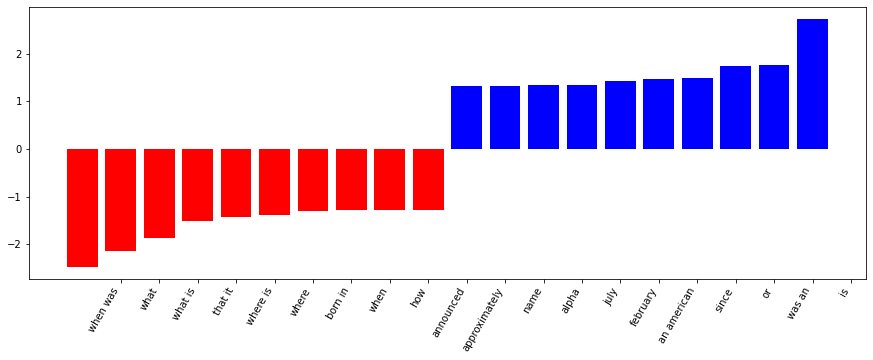

1


IndexError: index 1 is out of bounds for axis 0 with size 1

In [139]:
top_features = 10
# get the model's weights: n_classes x n_features - (? , ?)
all_class_coef = lr.coef_

for i, cls in enumerate(lr.classes_): # for each of the classes
  print(cls)
  # get the weights for the class
  coef = all_class_coef[i]
  # find the top negative and positive features for the class
  top_positive_coefficients = np.argsort(coef)[-top_features:]
  top_negative_coefficients = np.argsort(coef)[:top_features]
  # combine them in one array
  top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
  # create plot - humans tend to understand better plot visualizations
  feature_names = vectorizer.get_feature_names()
  plt.figure(figsize=(15, 5))
  colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
  plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
  feature_names = np.array(feature_names)
  plt.xticks(np.arange(1, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
  plt.show()

In [140]:
lr.classes_

array([0, 1])